# `meerpower` demonstrative Jupyter notebook
#### `https://github.com/meerklass/meerpower`

This notebook provides a walkthrough of some of the main `meerpower` features using real MeerKAT single-dish 2021 L-band survey data.

**Ensure amended filepath is added in first block to location of cloned code**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

### CHANGE BELOW TO LOCATION OF CLONED meerpower REPO: ######
#############################################################
meerpower_filepath = '/idia/projects/hi_im/meerpower/meerpower'
#############################################################
#############################################################

sys.path.insert(1,meerpower_filepath)
import Init
import plot

### Example file paths to saved level6 data:

In [2]:
####### AMEND THESE TO CHOSEN DATA OR CAN CHANGE PATHS TO LOCAL FILES IF RUNNING LOCALLY ######
filestem = '/idia/projects/hi_im/raw_vis/MeerKLASS2021/level6/0.3/sigma_3/data/'
map_file = filestem + 'Nscan966_Tsky_cube_p0.3d_sigma3.0_iter2.fits'
counts_file = filestem + 'Nscan966_Npix_count_cube_p0.3d_sigma3.0_iter2.fits'

### Read-in maps and coordinates:

In [3]:
MKmap,w,W,counts,dims,ra,dec,nu,wproj = Init.ReadIn(map_file,counts_file)

### Initialise some fiducial cosmology and survey parameters:
import cosmo
nu_21cm = 1420.405751 #MHz
zeff = (nu_21cm/np.median(nu)) - 1 # Effective redshift (redshift of median frequency)
cosmo.SetCosmology(builtincosmo='Planck18',z=zeff,UseCLASS=True)
Pmod = cosmo.GetModelPk(zeff,kmax=25,UseCLASS=True) # high-kmax needed for large k-modes in NGP alisasing correction
f = cosmo.f(zeff)
sig_v = 0
b_HI = 1.5
OmegaHI = 1.333333e-3
import HItools
import telescope
Tbar = HItools.Tbar(zeff,OmegaHI)
D_dish = 13.5 # Dish-diameter [metres]
theta_FWHM,R_beam = telescope.getbeampars(D_dish,np.median(nu))

### Remove incomplete LoS pixels from maps:
MKmap,w,W,counts = Init.FilterIncompleteLoS(MKmap,w,W,counts)

### Trim map edges (can fine-tune boarders if needed):
raminMK,ramaxMK = 334,357
decminMK,decmaxMK = -35,-26.5
MKmap_untrim,W_untrim = np.copy(MKmap),np.copy(W) #before trimming, copy map to show impact of trim on map
MKmap,w,W,counts = Init.MapTrim(ra,dec,MKmap,w,W,counts,ramin=raminMK,ramax=ramaxMK,decmin=decminMK,decmax=decmaxMK)

### Plot maps and spectra:

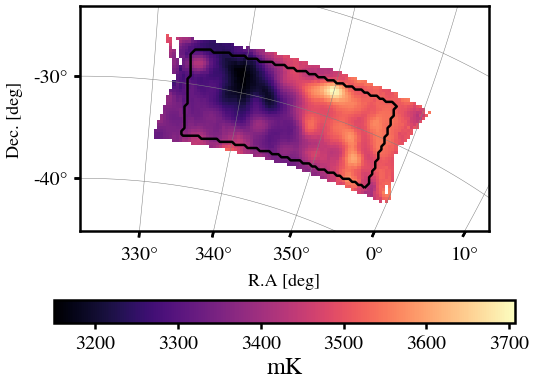

<Figure size 576x432 with 0 Axes>

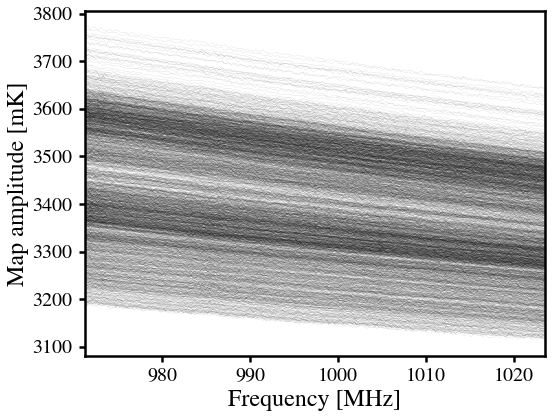

In [4]:
plot.Map(MKmap_untrim,W=W_untrim,map_ra=ra,map_dec=dec,wproj=wproj)
plt.contour(W[:,:,0].T, levels=[0.5], colors='black')

plot.LoSspectra(MKmap,W=W,zaxis=nu,xlabel='Frequency [MHz]',lw=0.05)
plt.show()

### Examine PCA eigenmodes and covariance matrix:

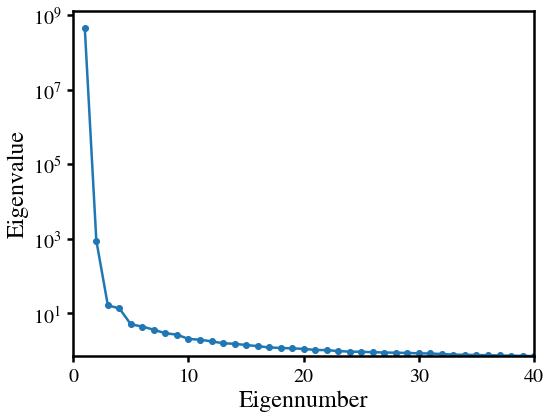

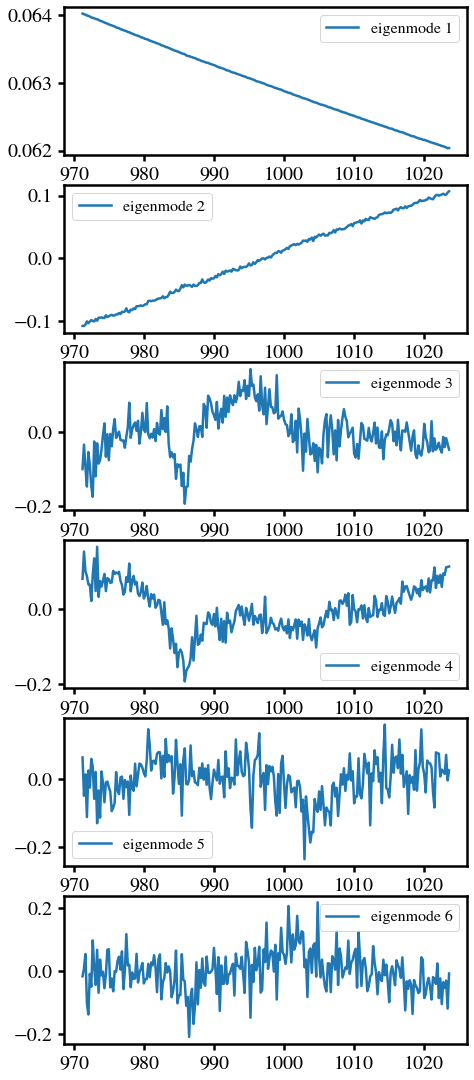

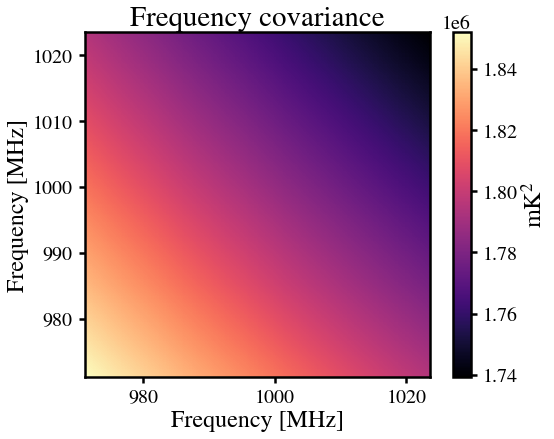

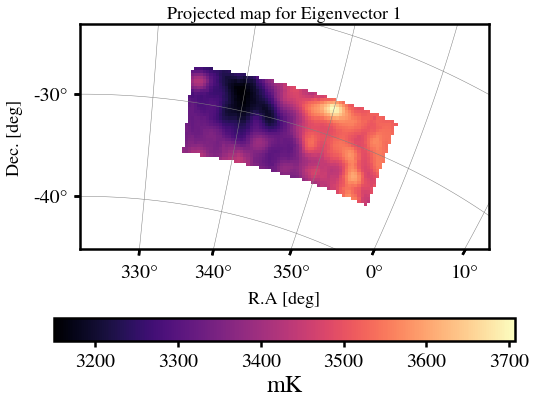

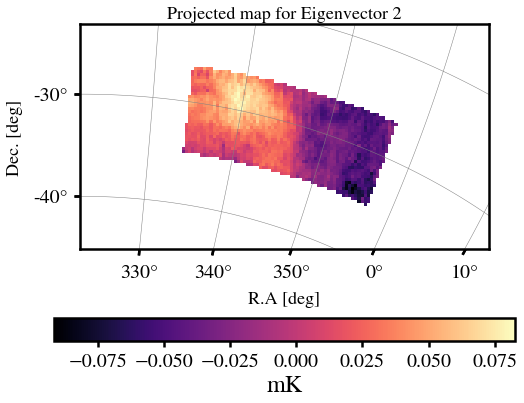

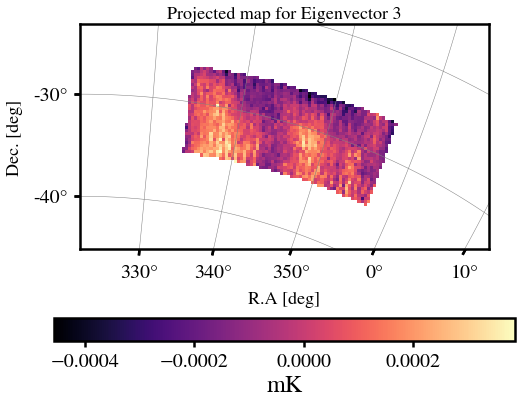

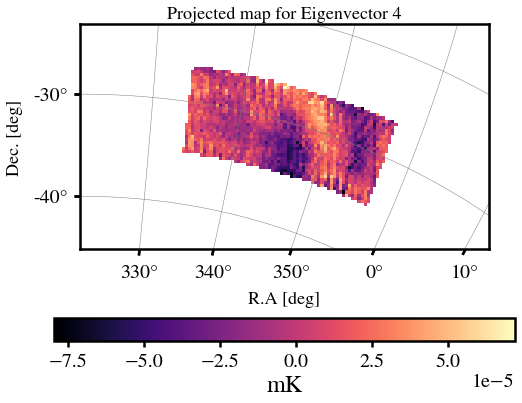

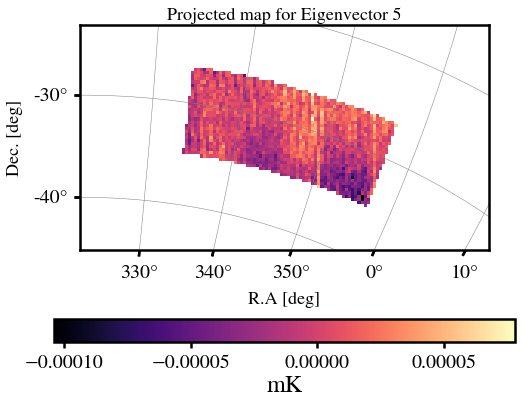

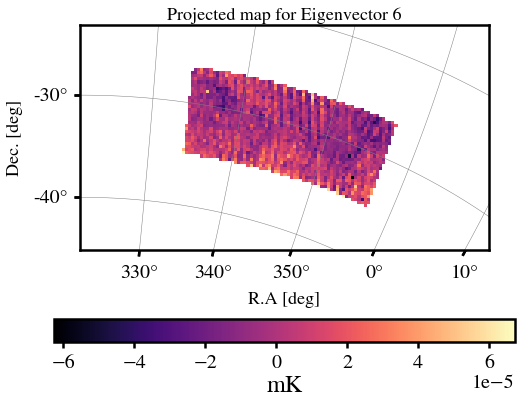

In [5]:
import foreground
C,eignumb,eigenval,V = foreground.PCAclean(MKmap,N_fg=1,W=W,w=None,returnAnalysis=True)
plot.EigenSpectrum(eignumb,eigenval)
plot.Eigenmodes(nu,V)
plot.FrequencyCovariance(C,nu)
plot.ProjectedEigenmodeMaps(MKmap,W,V,ra,dec,wproj)
plt.show()

### Plot foreground cleaned maps:

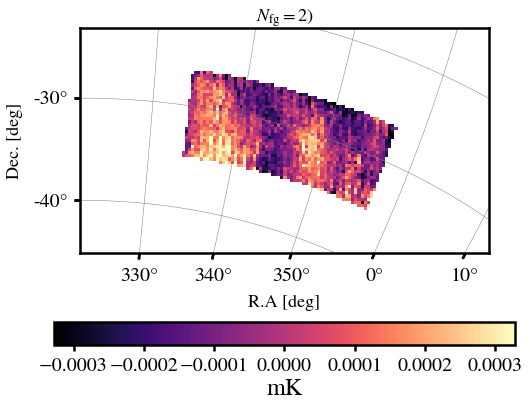

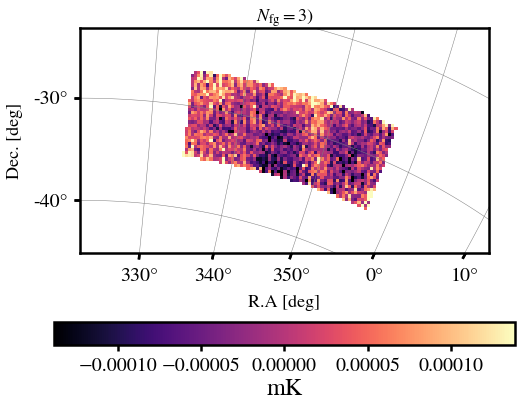

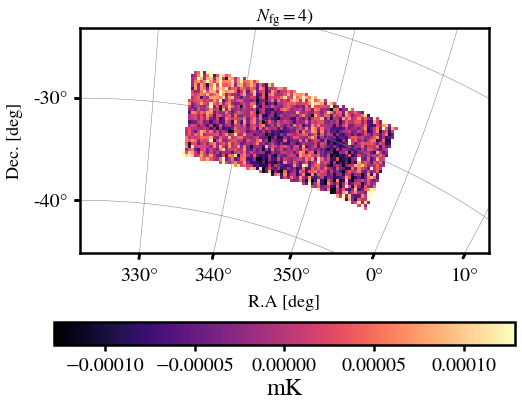

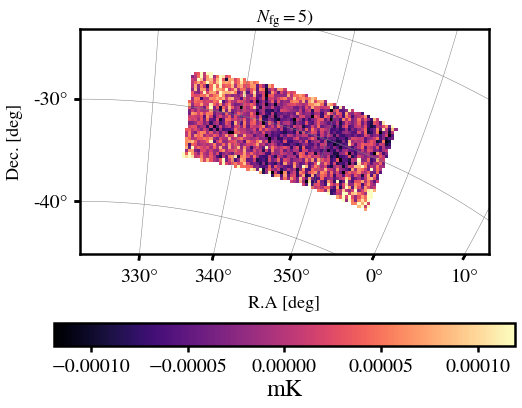

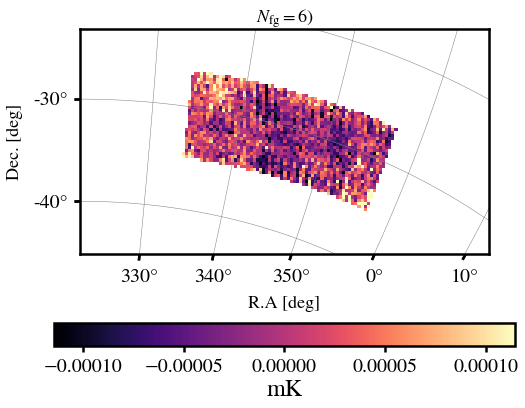

In [6]:
N_fgs = [2,3,4,5,6]
for i in range(len(N_fgs)):
    MKmap_clean = foreground.PCAclean(MKmap,N_fg=N_fgs[i],W=W,w=None)
    mapcut = 5*np.std(np.mean(MKmap_clean,2))
    mapcut = np.max(mapcut)
    plot.Map(MKmap_clean,map_ra=ra,map_dec=dec,wproj=wproj,W=W,title=r'$N_{\rm fg}=%s)$'%N_fgs[i],vmin=-mapcut,vmax=mapcut)
plt.show()

### Choose a final $N_{\rm fg}$ to use in power spectrum estimation:

In [7]:
N_fg = 6
MKmap_clean = foreground.PCAclean(MKmap,N_fg=N_fg,W=W,w=None)

### Re-grid (R.A.,Dec.,$\nu$) maps to Cartesian (x,y,z [Mpc/h]) field:

In [8]:
import grid # use this for going from (ra,dec,freq)->(x,y,z) Cartesian-comoving grid
window = 'ngp' # mass assignment function for particle resamping
compensate = True # correct for smoothing to field from particle assignment
interlace = True # interlace fields for further alias suppression
Np = 5 # number of Monte-Carlo sampling particles per map voxel used in regridding
nxmap,nymap = np.shape(MKmap)[:2]
nzmap = len(nu)
cell2vox_factor = 1.5 # increase for lower resolution FFT Cartesian grid
nzcell2vox = int(nzmap/cell2vox_factor)
if nzcell2vox % 2 != 0: nzcell2vox += 1 # Ensure z-dimension is even for FFT purposes
ndim_rg = int(nxmap/cell2vox_factor),int(nymap/cell2vox_factor),nzcell2vox
dims_rg,dims0_rg = grid.comoving_dims(ra,dec,nu,wproj,ndim_rg,W=W) # dimensions of Cartesian grid for FFT
lx,ly,lz,nx_rg,ny_rg,nz_rg = dims_rg

# Regrid cleaned map to Cartesian field:
ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=MKmap_clean,W=W,Np=Np)
xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
MKmap_clean_rg,W_fft,counts = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window,compensate,interlace,verbose=False)

# Regrid IM weights to Cartesian field (regrid HI IM map later after foreground cleaning):
ra_p,dec_p,nu_p,pixvals = grid.SkyPixelParticles(ra,dec,nu,wproj,map=w,W=W,Np=Np)
xp,yp,zp = grid.SkyCoordtoCartesian(ra_p,dec_p,HItools.Freq2Red(nu_p),ramean_arr=ra,decmean_arr=dec,doTile=False)
w_rg,W_fft,counts = grid.mesh(xp,yp,zp,pixvals,dims0_rg,window,compensate,interlace,verbose=False)

# Grid uncut pixels to obtain binary masks in Cartesian space:
ra_p,dec_p,nu_p = grid.SkyPixelParticles(ra,dec,nu,wproj,Np=Np)
MKcutmask = (ra_p>raminMK) & (ra_p<ramaxMK) & (dec_p>decminMK) & (dec_p<decmaxMK)
xp,yp,zp = grid.SkyCoordtoCartesian(ra_p[MKcutmask],dec_p[MKcutmask],HItools.Freq2Red(nu_p[MKcutmask]),ramean_arr=ra,decmean_arr=dec,doTile=False)
null,W_rg,counts = grid.mesh(xp,yp,zp,dims=dims0_rg,window='ngp',compensate=False,interlace=False,verbose=False)

### Plot regridded maps in comoving space:

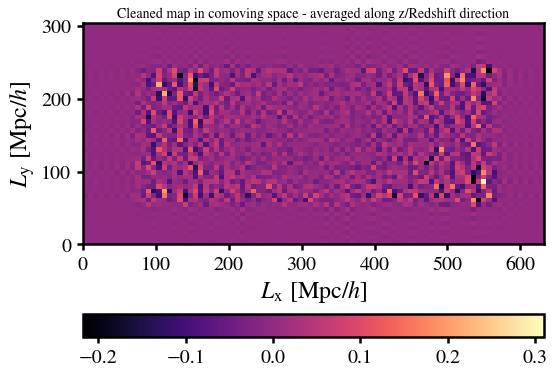

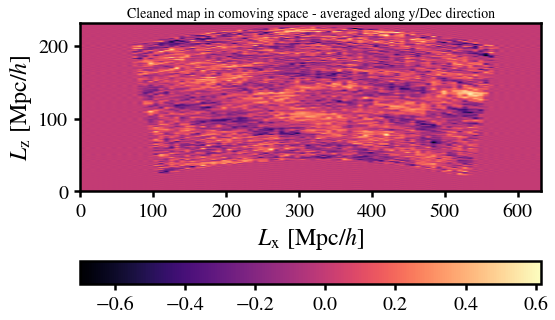

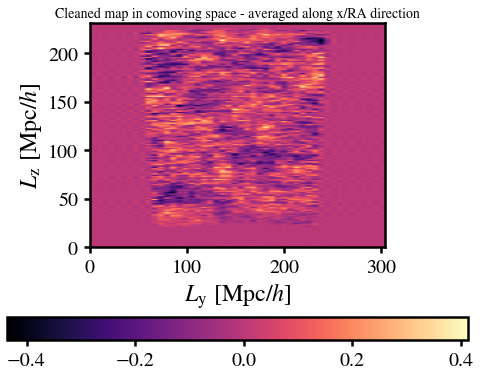

In [9]:
map_nan = np.mean(MKmap_clean_rg,2).T
map_nan[map_nan==0] = np.nan
plt.imshow(map_nan,extent=[0,lx,0,ly])
plt.xlabel(r'$L_{\rm x}$ [Mpc/$h$]')
plt.ylabel(r'$L_{\rm y}$ [Mpc/$h$]')
plt.colorbar(orientation='horizontal',pad=0.2)
plt.title('Cleaned map in comoving space - averaged along z/Redshift direction',fontsize=14)
plt.figure()
map_nan = np.mean(MKmap_clean_rg,1).T
map_nan[map_nan==0] = np.nan
plt.imshow(map_nan,extent=[0,lx,0,lz])
plt.xlabel(r'$L_{\rm x}$ [Mpc/$h$]')
plt.ylabel(r'$L_{\rm z}$ [Mpc/$h$]')
plt.colorbar(orientation='horizontal',pad=0.2)
plt.title('Cleaned map in comoving space - averaged along y/Dec direction',fontsize=14)
plt.figure()
map_nan = np.mean(MKmap_clean_rg,0).T
map_nan[map_nan==0] = np.nan
plt.imshow(map_nan,extent=[0,ly,0,lz])
plt.xlabel(r'$L_{\rm y}$ [Mpc/$h$]')
plt.ylabel(r'$L_{\rm z}$ [Mpc/$h$]')
plt.colorbar(orientation='horizontal',pad=0.2)
plt.title('Cleaned map in comoving space - averaged along x/RA direction',fontsize=14)
plt.show()

### Power spectrum measurement and modelling:

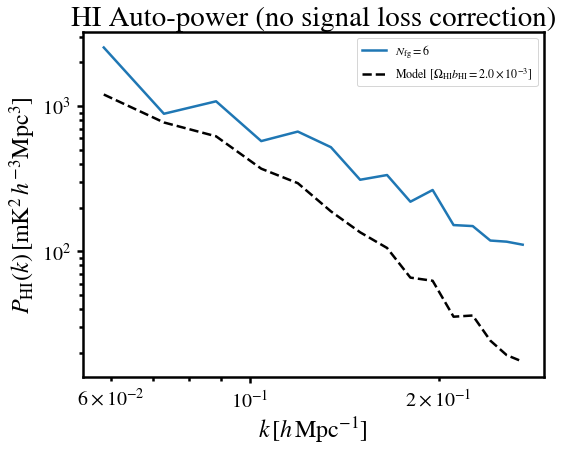

In [10]:
import power # All power spectrum calculations performed in this script
import model
nkbin = 15
kmin,kmax = 0.05,0.28
kbins = np.linspace(kmin,kmax,nkbin+1) # k-bin edges [using linear binning]

# Measure and plot power spectrum:
Pk,k,nmodes = power.Pk(MKmap_clean_rg,MKmap_clean_rg,dims_rg,kbins,corrtype='HIauto',w1=w_rg,w2=w_rg,W1=W_rg,W2=W_rg)
plt.plot(k,Pk,label=r'$N_{\rm fg}=%s$'%N_fgs[i])
pkmod,k = model.PkMod(Pmod,dims_rg,kbins,b_HI,b_HI,f,sig_v,Tbar1=Tbar,Tbar2=Tbar,r=1,R_beam1=R_beam,R_beam2=R_beam,w1=w_rg,w2=w_rg,W1=W_rg,W2=W_rg,interpkbins=True,gridinterp=True)[0:2]
plt.plot(k,pkmod,color='black',ls='--',label=r'Model [$\Omega_{\rm HI}b_{\rm HI} = %s \times 10^{-3}]$'%np.round(OmegaHI*b_HI*1e3,2))
plt.loglog()
plt.legend(fontsize=12,loc='upper right')
plt.title('HI Auto-power (no signal loss correction)')
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm HI}(k)\,[{\rm mK}^2\,h^{-3}{\rm Mpc}^{3}]$')
plt.show()

### Compute/Load transfer function to correct for foreground cleaning signal loss and use for error analysis:

Errors for the reconstructed power spectrum $P_{\rm rec}(k) = P_{\rm clean}(k)/T(k)$ are propagated from the transfer function distributions $T(k)+\Delta T_i(k)$ obtained from each $i$th mock. We assume the errors add in quadrature, hence $\Delta P_{{\rm rec},i}/P_{\rm rec} = \sqrt{(\Delta P_{{\rm clean},i}/P_{\rm clean})^2 + (\Delta T_i/T)^2}$. We assume all quantifiable error lies in the TF distribution, hence $\Delta P_{{\rm clean},i} = 0$ and therefore $\Delta P_{{\rm rec},i} = P_{\rm rec} \frac{{\Delta T},i}{T}$. The uncertainties for the error bars can then be obtained from the 68th percentile regions of the reconstructed power distribution $P_{{\rm rec},i}(k) = P_{\rm rec}(k) + \Delta P_{{\rm rec},i}(k)$ 

50


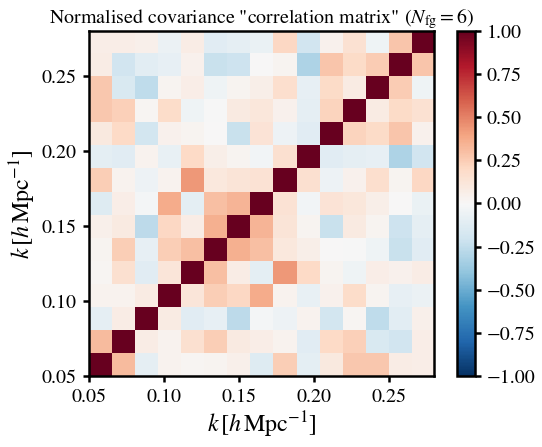

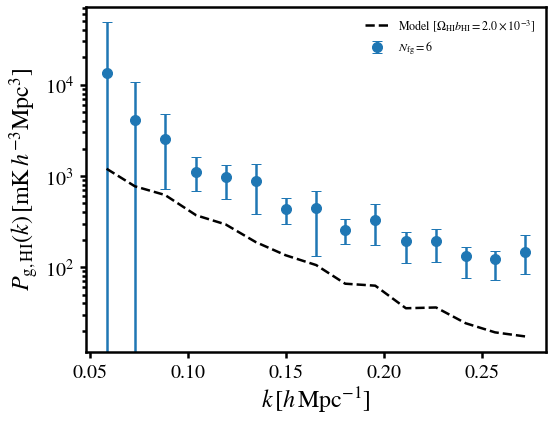

In [11]:
LoadTF = True
Nmock = 50 # number of mocks to use in TF calculation
TFfile = '/idia/projects/hi_im/meerpower/demo/TFdata/T_Nfg=%s'%N_fg # where to save transfer function output
mockfilepath_HI = '/idia/projects/hi_im/meerpower/2021Lband/mocks/dT_HI_p0.3d_wBeam' # pre-run lognormal mocks to use in TF calculation
T_wsub_i, T_nosub_i,k = foreground.TransferFunction(MKmap,Nmock,N_fg,'HIauto',kbins,k,TFfile,ra,dec,nu,wproj,dims0_rg,Np,window,compensate,interlace,mockfilepath_HI,W_HI=W,w_HI_rg=w_rg,W_HI_rg=W_rg,LoadTF=LoadTF)
Nmock = np.shape(T_wsub_i)[0]
print(Nmock)

T_i = np.copy(T_nosub_i)
T = np.median(T_i,0)
deltaT_i = T_i - T
Pk_rec = Pk/T

# Propagate error on TF into error on power:
deltaPk_i =  Pk_rec * (deltaT_i/T) 
Pk_rec_i = Pk_rec + deltaPk_i # corrected power uncertainty distribution

# Noramlised k-bin correlation matrix:
R = np.corrcoef(Pk_rec_i,rowvar=False)
plt.imshow(R,origin='lower',cmap='RdBu_r',vmin=-1,vmax=1,extent=[kbins[0],kbins[-1],kbins[0],kbins[-1]])
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.colorbar()
plt.title(r'Normalised covariance "correlation matrix" ($N_{\rm fg}=%s$)'%N_fg,fontsize=20)
plt.show()

# Calculate 68th percentile regions for non-symmetric/non-Gaussian errors:
### 68.27%/2 = 34.135%. So 50-34.135 -> 50+34.135 covers 68th percentile region:
lower_error = np.abs(np.percentile(deltaPk_i,15.865,axis=0))
upper_error = np.abs(np.percentile(deltaPk_i,84.135,axis=0))
asymmetric_error = np.array(list(zip(lower_error, upper_error))).T

# Plot results, correcting for signal loss and with simulation-based errors:
plt.errorbar(k,Pk_rec,asymmetric_error,ls='none',marker='o',label=r'$N_{\rm fg}=%s$'%N_fg,markersize=10)
plt.plot(k,pkmod,color='black',ls='--',label=r'Model [$\Omega_{\rm HI}b_{\rm HI} = %s \times 10^{-3}]$'%np.round(OmegaHI*b_HI*1e3,2))
plt.yscale('log')
plt.legend(fontsize=12,loc='upper right',frameon=False)
plt.xlabel(r'$k\,[h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$P_{\rm g,HI}(k)\,[{\rm mK}\,h^{-3}{\rm Mpc}^{3}]$')
plt.show()

### 2D Power:

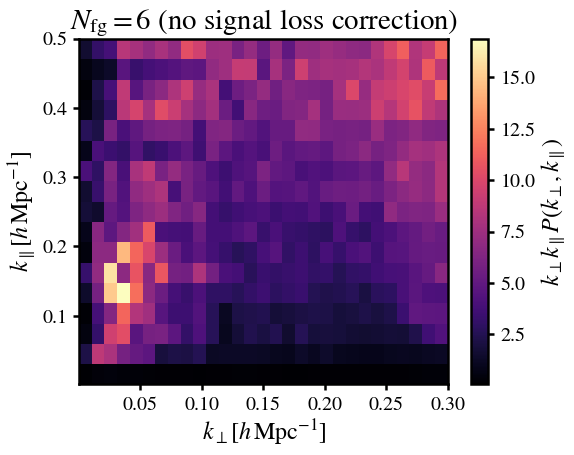

In [12]:
kperpbins = np.linspace(0.001,0.3,30)
kparabins = np.linspace(0.001,0.5,18)
kperpcen = (kperpbins[1:] + kperpbins[:-1])/2
kparacen = (kparabins[1:] + kparabins[:-1])/2
kgrid = kperpcen * kparacen[:,np.newaxis]
Pk2D,k2D,nmodes = power.Pk2D(MKmap_clean_rg,MKmap_clean_rg,dims_rg,kperpbins,kparabins,w1=w_rg,w2=w_rg,W1=W_rg,W2=W_rg)
vmax = np.max(kgrid*Pk2D)
plt.pcolormesh(kperpbins,kparabins,kgrid*Pk2D)
plt.colorbar(label=r'$k_\perp k_\parallel P(k_\perp,k_\parallel)$')
plt.xlabel(r'$k_\perp [h\,{\rm Mpc}^{-1}]$')
plt.ylabel(r'$k_\parallel [h\,{\rm Mpc}^{-1}]$')
plt.title(r'$N_{\rm fg}=%s$ (no signal loss correction)'%N_fgs[-1])
plt.show()